In [1]:
# import packages
import datetime
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
import umap
from sklearn.pipeline import Pipeline
from mpl_toolkits.mplot3d import Axes3D 
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Import necessary libraries for loading and processing data
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Import Keras for implementing autoencoders
import keras
from keras.models import Sequential
from keras.layers import Input, Dense

In [3]:
df = pd.read_csv('faults.csv')
df.head()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


In [4]:
#df_OHE = df[['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults']]
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

,count,mean,std,min,25%,50%,75%,max
X_Minimum,1941.0,5.711360e+02,5.206907e+02,0.0000,51.0000,4.350000e+02,1.053000e+03,1.705000e+03
X_Maximum,1941.0,6.179645e+02,4.976274e+02,4.0000,192.0000,4.670000e+02,1.072000e+03,1.713000e+03
Y_Minimum,1941.0,1.650685e+06,1.774578e+06,6712.0000,471253.0000,1.204128e+06,2.183073e+06,1.298766e+07
Y_Maximum,1941.0,1.650739e+06,1.774590e+06,6724.0000,471281.0000,1.204136e+06,2.183084e+06,1.298769e+07
Pixels_Areas,1941.0,1.893878e+03,5.168460e+03,2.0000,84.0000,1.740000e+02,8.220000e+02,1.526550e+05
X_Perimeter,1941.0,1.118552e+02,3.012092e+02,2.0000,15.0000,2.600000e+01,8.400000e+01,1.044900e+04
Y_Perimeter,1941.0,8.296600e+01,4.264829e+02,1.0000,13.0000,2.500000e+01,8.300000e+01,1.815200e+04
Sum_of_Luminosity,1941.0,2.063121e+05,5.122936e+05,250.0000,9522.0000,1.920200e+04,8.301100e+04,1.159141e+07
Minimum_of_Luminosity,1941.0,8.454869e+01,3.213428e+01,0.0000,63.0000,9.000000e+01,1.060000e+02,2.030000e+02
Maximum_of_Luminosity,1941.0,1.301937e+02,1.869099e+01,37.0000,124.0000,1.270000e+02,1.400000e+02,2.530000e+02


In [5]:
df.columns = map(str.lower, df.columns)

In [6]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults'] 
# list of the features of the steel plates
feat_col = ['x_minimum', 'x_maximum', 'y_minimum', 'y_maximum', 'pixels_areas', 'x_perimeter', 'y_perimeter', 'sum_of_luminosity', 'minimum_of_luminosity', 'maximum_of_luminosity', 'length_of_conveyer', 'typeofsteel_a300', 'typeofsteel_a400', 'steel_plate_thickness', 'edges_index', 'empty_index', 'square_index', 'outside_x_index', 'edges_x_index', 'edges_y_index', 'outside_global_index', 'logofareas', 'log_x_index', 'log_y_index', 'orientation_index', 'luminosity_index', 'sigmoidofareas'] 

In [7]:
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} # mapper for the encoding

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)

In [8]:
df.drop(391, inplace = True) # remove troublesome outlier

In [9]:
X = df[feat_col]
y = df['anomaly']

In [10]:
sm = SMOTE(random_state = 2)

In [11]:
X = df[feat_col]
y = df['anomaly']
X_res, y_res = sm.fit_resample(X, y)

In [12]:
df_res = pd.merge(pd.DataFrame(X_res), pd.DataFrame(y_res), right_index = True, left_index = True)

In [13]:
anomaly_count_res = pd.DataFrame(df_res['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

,count
pastry,673
z_scratch,673
k_scatch,673
stains,673
dirtiness,673
bumps,673
other_faults,673


In [14]:
# Standardize the data
scaler = StandardScaler()
df = scaler.fit_transform(df)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

In [15]:
# Define the autoencoder architecture
input_dim = X_train.shape[1]
encoding_dim = 5

# Set the encoding dimension
input_layer = keras.layers.Input(shape=(input_dim,))
encoder = keras.layers.Dense(encoding_dim, activation="relu")(input_layer)
decoder = keras.layers.Dense(input_dim, activation="sigmoid")(encoder)
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

# Summary of the autoencoder architecture
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 35)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 35)             │           210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 390 (1.52 KB)

 Trainable params: 390 (1.52 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, shuffle=True, validation_data=(X_test, X_test))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.2300 - val_loss: 1.2266
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1342 - val_loss: 1.1549
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0835 - val_loss: 1.0773
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0304 - val_loss: 1.0088
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9701 - val_loss: 0.9558
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8983 - val_loss: 0.9169
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8761 - val_loss: 0.8880
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8422 - val_loss: 0.8652
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8507 - val_loss: 0.8469
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8006 - val_loss: 0.8323
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7976 - val_loss: 0.8208
Epoch 12/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7

In [17]:
# Use encoder part of the autoencoder for feature selection
encoder = keras.Model(inputs=autoencoder.input, outputs=autoencoder.layers[1].output)
encoded_features_train = encoder.predict(X_train)
encoded_features_test = encoder.predict(X_test)

# Display the shape of extracted features
print("Encoded Features Shape (Train):", encoded_features_train.shape)
print("Encoded Features Shape (Test):", encoded_features_test.shape)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Encoded Features Shape (Train): (1552, 5)
Encoded Features Shape (Test): (388, 5)


In [18]:
# Initialize the SVM classifier
svm_classifier = SVC(kernel='linear', random_state=42)

# Train the SVM using the encoded training features
svm_classifier.fit(encoded_features_train, y_train)

# Predict on the test set using the encoded features
y_pred = svm_classifier.predict(encoded_features_test)

In [19]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9742268041237113


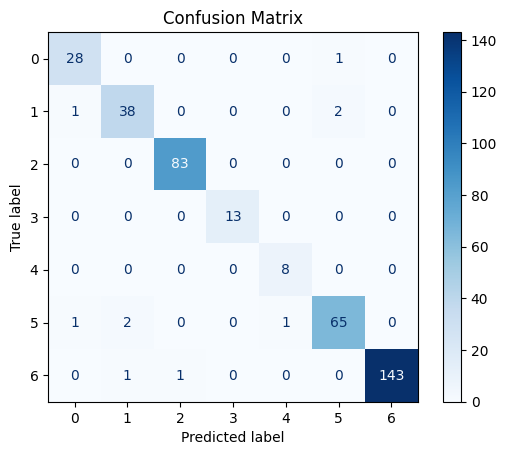

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_classifier.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

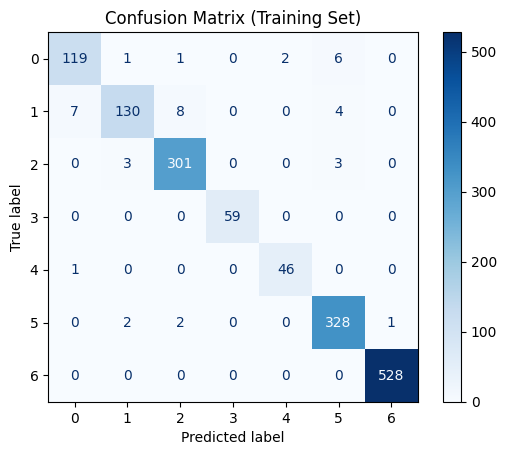

In [21]:
# Predict on the training set
y_train_pred = svm_classifier.predict(encoded_features_train)

# Compute the confusion matrix for the training set
cm_train = confusion_matrix(y_train, y_train_pred)

# Plot the confusion matrix for the training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=svm_classifier.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Training Set)")
plt.show()

In [22]:
print("Accuracy:", accuracy_score(y_train, y_train_pred))

Accuracy: 0.9735824742268041
